In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])
import warnings


In [2]:
df = pd.read_csv('/Users/spark/OneDrive/ps/AIBI/Wine/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from lightgbm import plot_importance, plot_metric, plot_tree

In [5]:
# creating X and y
X = df.drop('quality', axis = 1)
y = df['quality']


In [6]:
# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y)

In [7]:
# scaling data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
y_train


1096    6
901     7
258     5
1125    7
1338    5
       ..
1507    6
203     5
1409    6
507     6
571     6
Name: quality, Length: 1199, dtype: int64

train과 fit의 차이 
https://www.kaggle.com/questions-and-answers/65417

In [24]:
import lightgbm as lgb

lgb_dtrain = lgb.Dataset(data = X_train, label = y_train) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 100, # Number of trees, 트리 생성 개수
            'objective': 'multiclass', # 목적 함수
            'num_class': len(y_train) + 1,
            'force_col_wise':True } # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
lgb_model_predict = np.argmax(lgb_model.predict(X_test), axis = 1) # 평가 데이터 예측, Softmax의 결과값 중 가장 큰 값의 Label로 예측





/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 1001
[LightGBM] [Info] Number of data points in the train set: 1199, number of used features: 11
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -5.009802
[LightGBM] [Info] Start training from score -3.400364
[LightGBM] [Info] Start training from score -0.852874
[LightGBM] [Info] Start training from score -0.919632
[LightGBM] [Info] Start training from score -2.085297
[LightGBM] [Info] Start training from score -4.524294
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Inf

In [10]:
print("Accuracy: %.2f" % (accuracy_score(y_test, lgb_model_predict) * 100), "%") # 정확도 % 계산
print('오차행렬:\n',confusion_matrix(y_test,lgb_model_predict))

Accuracy: 64.25 %
오차행렬:
 [[  0   0   2   0   0   0]
 [  0   0   8   5   0   0]
 [  0   0 126  44   0   0]
 [  0   2  36 114   8   0]
 [  0   0   2  30  17   1]
 [  0   0   0   4   1   0]]


In [11]:
lgbmc = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]

lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', 
          eval_set=evals, verbose=True)

preds = lgbmc.predict(X_test)

lgbmc_acc = accuracy_score(y_test, lgbmc.predict(X_test))

[1]	valid_0's multi_logloss: 1.11884
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.07467
[3]	valid_0's multi_logloss: 1.04065
[4]	valid_0's multi_logloss: 1.01247
[5]	valid_0's multi_logloss: 0.988345
[6]	valid_0's multi_logloss: 0.972809
[7]	valid_0's multi_logloss: 0.959037
[8]	valid_0's multi_logloss: 0.9455
[9]	valid_0's multi_logloss: 0.939128
[10]	valid_0's multi_logloss: 0.933363
[11]	valid_0's multi_logloss: 0.927053
[12]	valid_0's multi_logloss: 0.921384
[13]	valid_0's multi_logloss: 0.916081
[14]	valid_0's multi_logloss: 0.906881
[15]	valid_0's multi_logloss: 0.901923
[16]	valid_0's multi_logloss: 0.896352
[17]	valid_0's multi_logloss: 0.894106
[18]	valid_0's multi_logloss: 0.885844
[19]	valid_0's multi_logloss: 0.882007
[20]	valid_0's multi_logloss: 0.878734
[21]	valid_0's multi_logloss: 0.876342
[22]	valid_0's multi_logloss: 0.876494
[23]	valid_0's multi_logloss: 0.877044
[24]	valid_0's multi_logloss: 0.875232
[25]	valid_0's mu

In [12]:
cross_val = cross_validate(
    estimator=lgbmc,
    X=X, y=y,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))


avg fit time: 2.8421812534332274 (+/- 0.4721304492051579)
avg score time: 0.013589143753051758 (+/- 0.00048647500838494817)
avg test score: 0.5447237460815046 (+/- 0.02995080073642768)


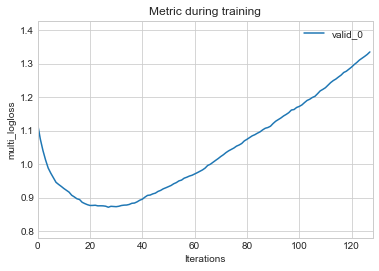

In [13]:
plot_metric(lgbmc);

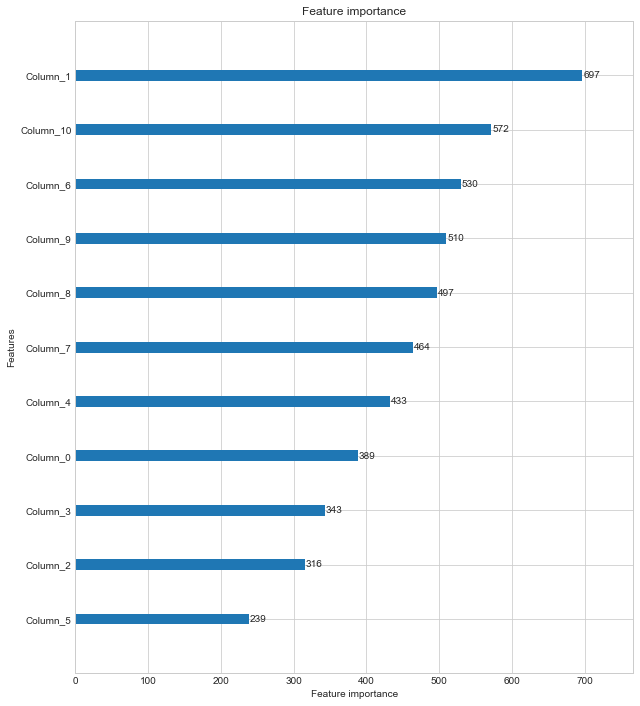

In [14]:
plot_importance(lgbmc,figsize=(10, 12));
#주요변수 alcohol, volatile acidity,total sulfur dioxide

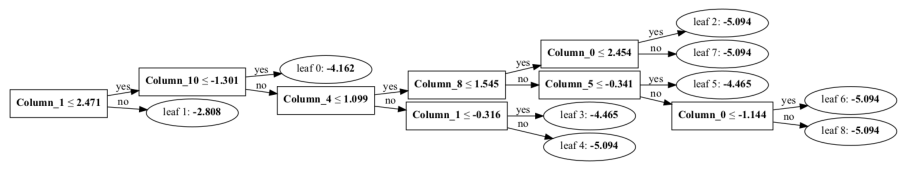

In [15]:
plot_tree(lgbmc, figsize=(16,10));

In [25]:
print(f"Training Accuracy of LGBM Classifier is {accuracy_score(y_train, lgbmc.predict(X_train))}")
print(f"Test Accuracy of LGBM Classifier is {lgbmc_acc} \n")
print('오차행렬:\n',confusion_matrix(y_test,preds))

Training Accuracy of LGBM Classifier is 0.9741451209341118
Test Accuracy of LGBM Classifier is 0.6925 

오차행렬:
 [[  0   0   2   0   0   0]
 [  0   0   8   5   0   0]
 [  0   0 128  38   4   0]
 [  0   1  28 120  11   0]
 [  0   0   0  20  29   1]
 [  0   0   0   3   2   0]]
